# Random Forest
In notebook 01, we prepared train and valid sets
from the H&E Image.csv rows 
In Notebook 02, we trained RF classifier in one round of CV.
Here, filter by RBC stats.

In [1]:
import datetime
print(datetime.datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import matplotlib as plt
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-07-15 06:45:23.858155
Python 3.8.10
sklearn 1.0.2


In [2]:
# Shuffle X,y in tandem.
from sklearn.utils import shuffle
# The model
from sklearn.ensemble import RandomForestClassifier

# This generates one split after shuffling. By default, not stratified.
# from sklearn.model_selection import train_test_split
# This does stratified K-fold cross-validation with no shuffling.
# from sklearn.model_selection import cross_val_score

#from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.metrics import confusion_matrix
#from sklearn.feature_selection import RFE
#import joblib # used to dump/load sklearn models
#from CellProfiler_Util import CP_Util
#from RandomForestUtil import RF_Util

## Prepare train and valid sets

In [3]:
# Prepare to divy up patches stratified by patient.
DF_Ypos = ['B7_','B15','D1_','D5_','E7_','E9_','F9_','G3_','H13','I1_','I5_','I13']
DF_Yneg = ['A3_','A5_','B13','C1_','C11','D3_','E5_','F3_','F7_','F11','F15','G15','H1_','H3_','H7_','H15']
ALL_PATIENTS = DF_Ypos + DF_Yneg
NUM_FOLDS=4  # because both sets have size = multiple of 4
print('All patients',ALL_PATIENTS)
print('Count Ypos:Yneg',len(DF_Ypos),len(DF_Yneg))
print('Hold out these patients for validation in each cross-validation fold.')
def make_folds():
    rpos = shuffle(DF_Ypos)  # fix random state?
    rneg = shuffle(DF_Yneg)  # fix random state?
    folds_pos = [rpos[0:3],rpos[3:6],rpos[6:9],rpos[9:12]]
    folds_neg = [rneg[0:4],rneg[4:8],rneg[8:12],rneg[12:16]]
    for i in range(4):
        print('Fold %d pos, neg:'%i,end=' ')
        print(folds_pos[i],folds_neg[i])
    return folds_pos,folds_neg
Ypos_valid_patients,Yneg_valid_patients = make_folds()

All patients ['B7_', 'B15', 'D1_', 'D5_', 'E7_', 'E9_', 'F9_', 'G3_', 'H13', 'I1_', 'I5_', 'I13', 'A3_', 'A5_', 'B13', 'C1_', 'C11', 'D3_', 'E5_', 'F3_', 'F7_', 'F11', 'F15', 'G15', 'H1_', 'H3_', 'H7_', 'H15']
Count Ypos:Yneg 12 16
Hold out these patients for validation in each cross-validation fold.
Fold 0 pos, neg: ['E9_', 'D5_', 'G3_'] ['C1_', 'G15', 'H1_', 'F3_']
Fold 1 pos, neg: ['H13', 'B7_', 'F9_'] ['B13', 'D3_', 'C11', 'H15']
Fold 2 pos, neg: ['I13', 'E7_', 'B15'] ['H3_', 'H7_', 'F7_', 'A5_']
Fold 3 pos, neg: ['I1_', 'I5_', 'D1_'] ['A3_', 'E5_', 'F11', 'F15']


In [4]:
BASE_PATH='/home/jrm/Martinez/CellProfilerRuns/CP_20220705/'
FILENAME='Process100_Image.csv'
def load_patient(p):
    filepath=BASE_PATH+p+'/'+FILENAME
    df = pd.read_csv(filepath)
    return df

In [5]:
def load_patients(fold):
    train_patients = list(ALL_PATIENTS)  # this will shrink
    valid_patients = []   # this will grow
    for patient in Ypos_valid_patients[fold]:
        train_patients.remove(patient)
        valid_patients.append(patient)
    for patient in Yneg_valid_patients[fold]:
        train_patients.remove(patient)
        valid_patients.append(patient)
    return train_patients,valid_patients

In [6]:
# Load csv rows for one fold
def load_fold(fold,train_patients,valid_patients):
    X_train=None
    y_train=None
    X_valid=None
    y_valid=None
    for patient in train_patients:
        df = load_patient(patient)
        func = np.ones
        if patient not in DF_Ypos:
            func = np.zeros
        if X_train is None:
            X_train = df
            y_train = func(len(df))
        else:
            X_train = pd.concat( (X_train,df) )
            y_train = np.concatenate( (y_train, func(len(df))))
    for patient in valid_patients:
        df = load_patient(patient)
        func = np.ones
        if patient not in DF_Ypos:
            func = np.zeros
        if X_valid is None:
            X_valid = df
            y_valid = func(len(df))
        else:
            X_valid = pd.concat( (X_valid,df) )
            y_valid = np.concatenate( (y_valid, func(len(df))))
    return X_train,y_train,X_valid,y_valid



In [7]:
fold = 0   # later do all folds
train_patients,valid_patients = load_patients(fold)  
print('Fold %d train patients'%fold)
print(train_patients)
print('Fold %d valid patients'%fold)
print(valid_patients)

X_train,y_train,X_valid,y_valid = load_fold(fold,train_patients,valid_patients)
print('Fold:',fold,'Patch Train set X:',X_train.shape,'y:',len(y_train))
print('Fold:',fold,'Patch Valid set X:',X_valid.shape,'y:',len(y_valid))

Fold 0 train patients
['B7_', 'B15', 'D1_', 'E7_', 'F9_', 'H13', 'I1_', 'I5_', 'I13', 'A3_', 'A5_', 'B13', 'C11', 'D3_', 'E5_', 'F7_', 'F11', 'F15', 'H3_', 'H7_', 'H15']
Fold 0 valid patients
['E9_', 'D5_', 'G3_', 'C1_', 'G15', 'H1_', 'F3_']
Fold: 0 Patch Train set X: (5795, 5304) y: 5795
Fold: 0 Patch Valid set X: (1927, 5304) y: 1927


In [8]:
# Expect nan for mean_RBC_diameter where #RBC=0
X_train.fillna(0,inplace=True)
X_valid.fillna(0,inplace=True)
nan = X_train.isna().sum().sum()
print('Number of remaining nan values:',nan)
# Expect no strings in X
temp_df=X_train.select_dtypes(include='object')
print('Number of string columns:',len(temp_df.columns>0))
# Expect no infinite values
inf = np.isinf(X_train).values.sum()
print('Number of infinite values:',inf)

Number of remaining nan values: 0
Number of string columns: 0
Number of infinite values: 0


## Filtering

array([[<AxesSubplot:title={'center':'AreaOccupied_AreaOccupied_Nucleus'}>]],
      dtype=object)

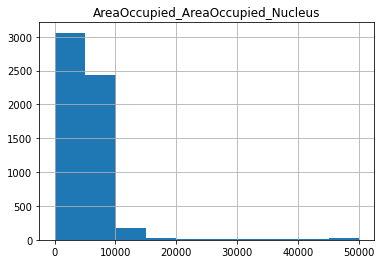

In [9]:
pd.DataFrame.hist(X_train,column='AreaOccupied_AreaOccupied_Nucleus')

array([[<AxesSubplot:title={'center':'AreaOccupied_AreaOccupied_MergeRBC'}>]],
      dtype=object)

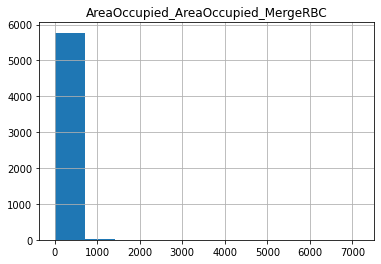

In [10]:
pd.DataFrame.hist(X_train,column='AreaOccupied_AreaOccupied_MergeRBC')

array([[<AxesSubplot:title={'center':'AreaOccupied_AreaOccupied_Tissue'}>]],
      dtype=object)

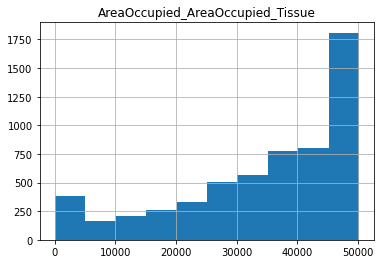

In [11]:
pd.DataFrame.hist(X_train,column='AreaOccupied_AreaOccupied_Tissue')

In [12]:
# By removing bad patches, we can improve accuracy at patch level.
# Assume we would then aggregate patch predictions to WSI level.
X_train = X_train[X_train.AreaOccupied_AreaOccupied_Tissue>10000]
X_train = X_train[X_train.AreaOccupied_AreaOccupied_MergeRBC<6000]

## Random Forest

In [13]:
print(datetime.datetime.now())
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

2022-07-15 06:45:32.337881


ValueError: Found input variables with inconsistent numbers of samples: [5252, 5795]

In [ ]:
print(datetime.datetime.now())
y_pred = rfc.predict(X_valid)
matches = np.count_nonzero(y_valid==y_pred)
accuracy = 100.0 * matches / len(y_pred)  
print('Accuracy:',accuracy)

In [ ]:
print(datetime.datetime.now())